Image shape: (128, 128)


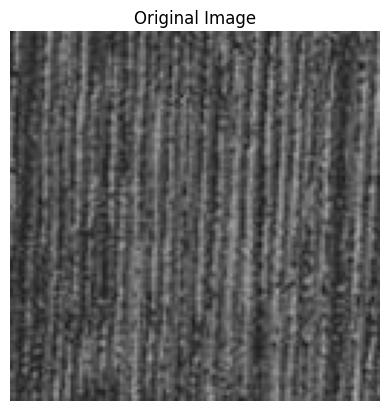

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('data\discharge_print_128x128.png')

# cv2 opens in BGR format for some reason
im_g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Recommended to convert to float32 do the mathematical expressions with more precision
im = im_g.astype(np.float32)

print(f"Image shape: {im.shape}")

plt.imshow(im.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("Original Image")
plt.axis('off')
plt.show()

## Gray version

Original shape: (128, 128) → Padded shape: (256, 256)


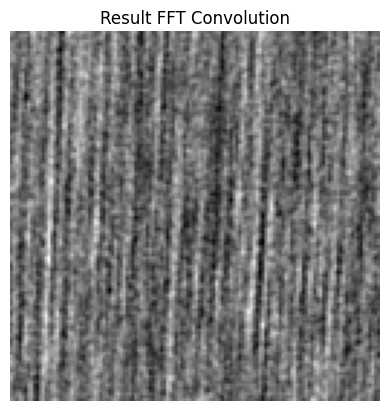

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def generate_zero_padding_kernel(im, k):
    pad_width = k // 2
    m, n = im.shape
    im_pad = np.zeros((m + 2 * pad_width, n + 2 * pad_width), dtype=im.dtype)
    im_pad[pad_width:-pad_width, pad_width:-pad_width] = im
    return im_pad

def generate_zero_padding_fft(im):
    m, n = im.shape
    im_pad = np.zeros((2 * m, 2 * n), dtype=im.dtype)
    im_pad[:m, :n] = im
    print("Original shape:", im.shape, "→ Padded shape:", im_pad.shape)
    return im_pad

def generate_gaussian_matrix(shape):
    return np.random.randn(*shape)

u = np.mean(im)
tu = (im - u) / np.sqrt(im.size)

tu_pad = generate_zero_padding_fft(tu)

W = generate_gaussian_matrix(tu_pad.shape)

tu_fft = np.fft.fft2(tu_pad)
W_fft = np.fft.fft2(W)

convolution = tu_fft * W_fft

im_convoluted = np.fft.ifft2(convolution)

im_convoluted_unpad = im_convoluted[:im.shape[0], :im.shape[1]]

result = u + np.real(im_convoluted_unpad)

final_result = np.clip(result, 0, 255).astype(np.uint8)

plt.imshow(final_result, cmap='gray')
plt.title("Result FFT Convolution")
plt.axis('off')
plt.show()


## RGB version

In [14]:
def generate_zero_padding_kernel(im, k):
    pad_width = k // 2

    if im.ndim == 3:
        m, n, c = im.shape
        im_pad = np.zeros((m + 2 * pad_width, n + 2 * pad_width, c), dtype=im.dtype)
        im_pad[pad_width:-pad_width, pad_width:-pad_width, :] = im
    elif im.ndim == 2:
        m, n = im.shape
        im_pad = np.zeros((m + 2 * pad_width, n + 2 * pad_width), dtype=im.dtype)
        im_pad[pad_width:-pad_width, pad_width:-pad_width] = im
    else:
        raise ValueError("Image must have either 2 or 3 dimensions")

    return im_pad

def generate_zero_padding_fft(im):
    m, n, c = im.shape
    im_pad = np.zeros((2*m, 2*n, c))
    im_pad[:m, :n, :] = im
    print(im.shape, im_pad.shape)
    return im_pad

def generate_gausian_matrix(shape):
    gaus = np.random.randn(*shape)

    return gaus

# This returns a mean vector (one mean for each channel)
u = np.mean(im, axis=(0, 1))


tu = (im - u)/np.sqrt(im[:,:,0].size)

tu_pad = generate_zero_padding_fft(tu)

W = generate_gausian_matrix(tu_pad.shape)

tu_fft = np.fft.fft2(tu_pad, axes=(0, 1))
W_fft = np.fft.fft2(W, axes=(0, 1))

convolution = tu_fft * W_fft

im_convoluted = np.fft.ifft2(convolution, axes=(0, 1))

# Remove padding
im_convoluted_unpad = im_convoluted[0:im.shape[0], 0:im.shape[1]]

# Remember to get that ifft returns a complex number!
result = u + np.real(im_convoluted_unpad)

# The previous operations make it so that result has negative values, we need to clip them
final_result = np.clip(result, 0, 255).astype(np.uint8)

plt.imshow(final_result)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# This returns a mean vector (one mean for each channel)
u = np.mean(im, axis=(0, 1))


tu = (im - u)


single_channel_noise = np.array(generate_gausian_matrix(tu.shape[0:2]))

W = np.dstack([single_channel_noise, single_channel_noise, single_channel_noise])

tu_fft = np.fft.fft2(tu, axes=(0, 1))
tu_mag = np.abs(tu_fft)
tu_phase = np.angle(tu_fft)


W_fft = np.fft.fft2(W, axes=(0, 1))
W_mag = np.abs(W_fft)
W_phase = np.angle(W_fft)

# Assemble both
result = tu_mag * np.exp(1j * W_phase)

image_gaussian_noise = np.fft.ifft2(result, axes=(0, 1))


# Remember to get that ifft returns a complex number!
result = u + np.real(image_gaussian_noise)

# The previous operations make it so that result has negative values, we need to clip them
final_result = np.clip(result, 0, 255).astype(np.uint8)

plt.imshow(final_result)

plt.show()

Problems:

- Generated three different gaussian noises, one for each color. Since they were randomized separately, this messed up the covariance between colors. To fix this i should have done one random and copy this to the other 2 channels -> Explained in the 3.1 section of the paper


- Maybe the convolution was wrong. I was not supposed to multiply the magnitude of the image and the gaussian noise's magnitude? Maybe preserve the magnitude from the original image and then just replace the phase by the gaussian's, proving that for textures that does not change anything.




Fix:
Generate three equal noises

Change the logic to:

U = v + F-1( |t_v|  /_ arg(W)+arg(W)  )

Basically we maintain the magnitude from our "bord" (the ohmega set) and randomize the phase, making it chaotic, as a microtexture should be.



OBS: Since im doing "manually", there will be no need to do the padding

In [23]:
def generate_zero_padding_kernel(im, k):
    pad_width = k // 2

    if im.ndim == 3:
        m, n, c = im.shape
        im_pad = np.zeros((m + 2 * pad_width, n + 2 * pad_width, c), dtype=im.dtype)
        im_pad[pad_width:-pad_width, pad_width:-pad_width, :] = im
    elif im.ndim == 2:
        m, n = im.shape
        im_pad = np.zeros((m + 2 * pad_width, n + 2 * pad_width), dtype=im.dtype)
        im_pad[pad_width:-pad_width, pad_width:-pad_width] = im
    else:
        raise ValueError("Image must have either 2 or 3 dimensions")

    return im_pad

def generate_zero_padding_fft(im):
    m, n, c = im.shape
    im_pad = np.zeros((2*m, 2*n, c))
    im_pad[:m, :n, :] = im
    print(im.shape, im_pad.shape)
    return im_pad

def generate_gausian_matrix(shape):
    gaus = np.random.randn(*shape)

    return gaus

(128, 128)


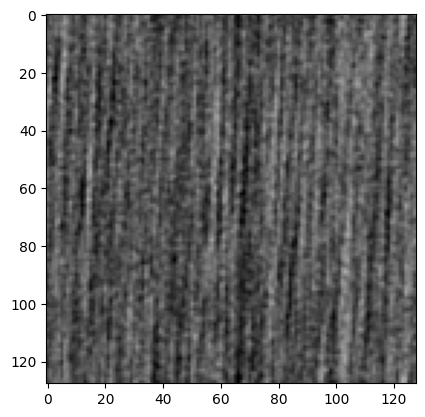

In [28]:
# This returns a mean vector (one mean for each channel)
u = np.mean(im, axis=(0, 1))


tu = (im - u)


W = np.array(generate_gausian_matrix(tu.shape))
print(W.shape)
tu_fft = np.fft.fft2(tu, axes=(0, 1))
tu_mag = np.abs(tu_fft)
tu_phase = np.angle(tu_fft)


W_fft = np.fft.fft2(W, axes=(0, 1))
W_mag = np.abs(W_fft)
W_phase = np.angle(W_fft)

# Assemble both
result = tu_mag * np.exp(1j * W_phase)

image_gaussian_noise = np.fft.ifft2(result, axes=(0, 1))


# Remember to get that ifft returns a complex number!
result = u + np.real(image_gaussian_noise)

# The previous operations make it so that result has negative values, we need to clip them
gaussian_impaint = np.clip(result, 0, 255).astype(np.uint8)

plt.imshow(gaussian_impaint, cmap='gray', vmin=0, vmax=255)

plt.show()

In [33]:

def generate_gaussian_impaint(im):
    u = np.mean(im, axis=(0, 1))


    tu = (im - u)


    single_channel_noise = np.array(generate_gausian_matrix(tu.shape[0:2]))

    W = np.dstack([single_channel_noise, single_channel_noise, single_channel_noise])

    tu_fft = np.fft.fft2(tu, axes=(0, 1))
    tu_mag = np.abs(tu_fft)
    tu_phase = np.angle(tu_fft)


    W_fft = np.fft.fft2(W, axes=(0, 1))
    W_mag = np.abs(W_fft)
    W_phase = np.angle(W_fft)

    # Assemble both
    result = tu_mag * np.exp(1j * W_phase)

    image_gaussian_noise = np.fft.ifft2(result, axes=(0, 1))


    # Remember to get that ifft returns a complex number!
    result = u + np.real(image_gaussian_noise)

    # The previous operations make it so that result has negative values, we need to clip them
    final_result = np.clip(result, 0, 255).astype(np.uint8)

    plt.imshow(final_result)

    plt.show()
    return final_result

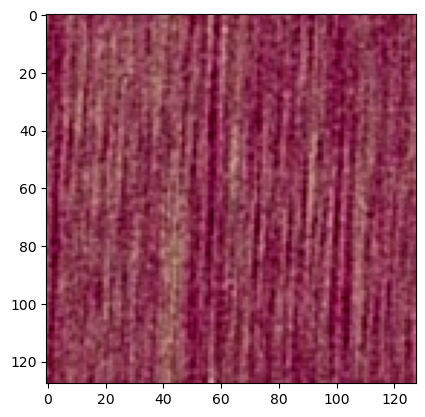

In [36]:
gaussian_impaint = generate_gaussian_impaint(im)

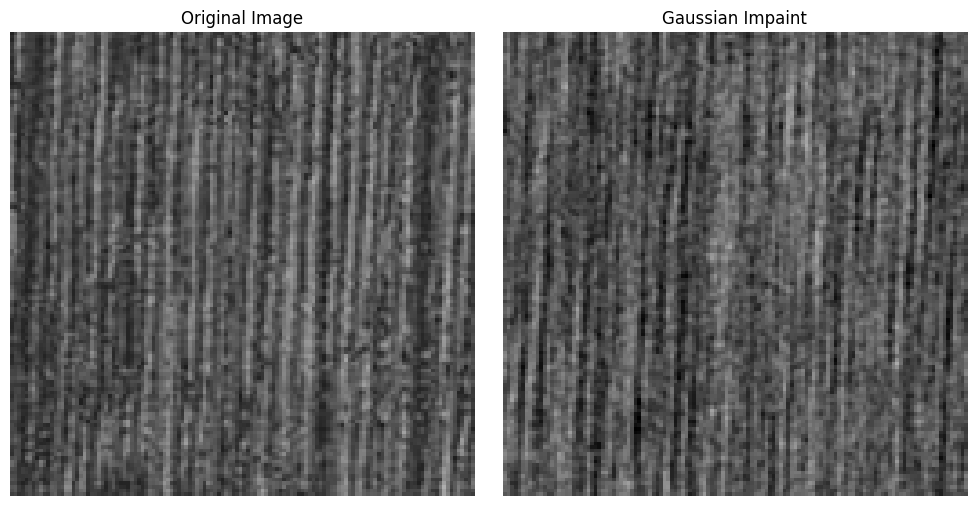

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # Adicionar figsize é uma boa prática


ax[0].imshow(im.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original Image")

ax[1].imshow(final_result, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Gaussian Impaint")

ax[0].axis('off')
ax[1].axis('off')

plt.tight_layout()

plt.show()

TO DO: add the masks to see the results

# Trying the second part: building masks

In [ ]:
# mask_coord = (center, size_x, size_y)
mask_size = ((128, 128), center, 30)
im.shape[0]//2 - mask_size[0]//2

49

In [35]:
129//2

64

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def create_rectangular_mask(image_shape, mask_center, mask_size):
    mask = np.full(image_shape[:2], False, dtype=bool) # Use image_shape[:2] for color images
    mask_height, mask_width = mask_size
    center_y, center_x = mask_center
    start_y, start_x = center_y - mask_height // 2, center_x - mask_width // 2
    end_y, end_x = start_y + mask_height, start_x + mask_width
    
    clipped_start_y = max(0, start_y)
    clipped_end_y = min(image_shape[0], end_y)
    clipped_start_x = max(0, start_x)
    clipped_end_x = min(image_shape[1], end_x)
    
    mask[clipped_start_y:clipped_end_y, clipped_start_x:clipped_end_x] = True
    return mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(128, 128))

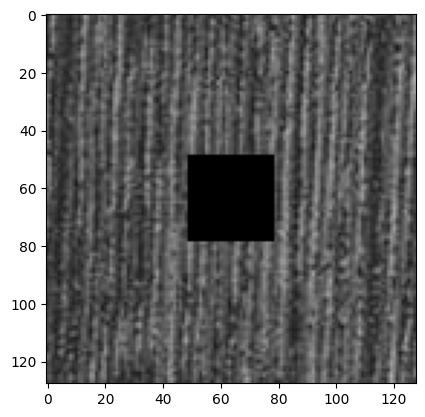

In [58]:
mask = create_rectangular_mask(im.shape, (im.shape[0]//2, im.shape[1]//2), (30,30))
im_hole = im.copy()
im_hole[mask] = 0

plt.imshow(im_hole, cmap='gray', vmin=0, vmax=255)
plt.show()

Calcular a Média (μ): Calcule o valor médio dos pixels na área conhecida da imagem (Ω \ M). Vamos chamar essa média de μ.</li>

Calcular a Função de Autocovariância (Cv(h)):
<li>Esta é a parte mais crítica. A função de covariância nos diz como a similaridade entre dois pixels varia com a distância e direção (h) entre eles.</li>
<li>Para cada possível deslocamento h = (dx, dy):</li>
<li>Percorra todos os pares de pixels (p1, p2) na área conhecida (Ω \ M) tal que p2 = p1 + h.</li>
<li>Calcule o produto dos seus valores centralizados na média: (valor(p1) - μ) * (valor(p2) - μ).</li>
<li>A covariância Cv(h) é a média desses produtos para um dado h.</li>
<li>Você precisa calcular e armazenar Cv(h) para todos os deslocamentos h que serão necessários para construir as matrizes na próxima fase.</li>

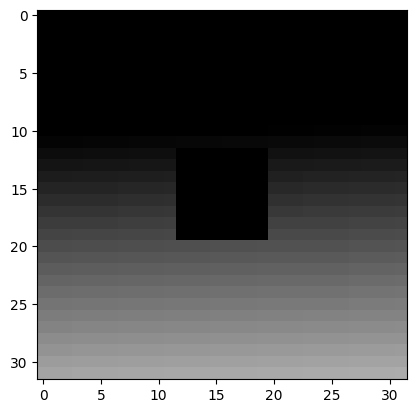

In [78]:
u = im_hole[im_hole != 0].mean()


im_centered = np.zeros_like(im)
im_centered[~mask] = im[~mask] - u

plt.imshow(im_centered, cmap='gray', vmin=0, vmax=255)
plt.show()

np.float32(43.96809)

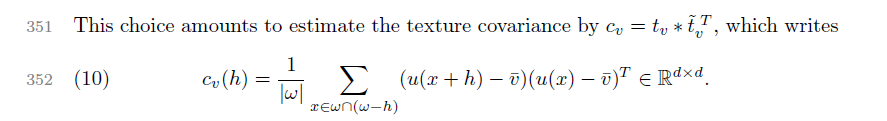

Usando uma imagem de teste de tamanho: (32, 32)

Iniciando o cálculo da autocovariância com loops...
Cálculo concluído em 0.49 segundos.
Encontrados 3969 deslocamentos 'h' únicos.


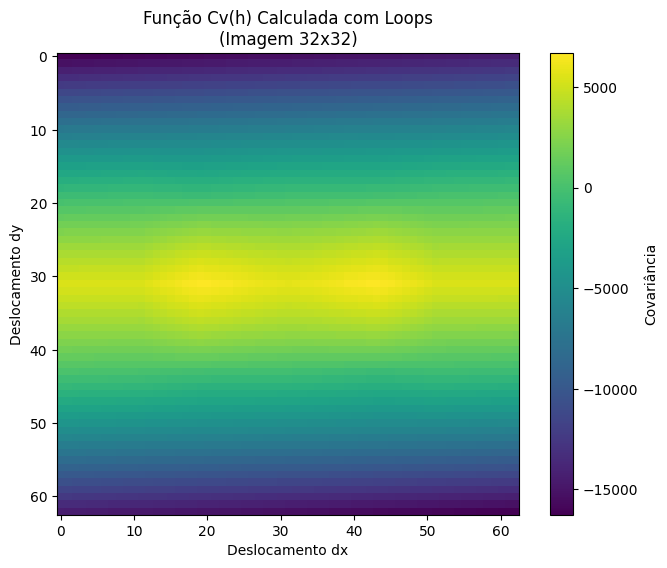

(31, 31)

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- 0. PREPARAÇÃO: Criar uma imagem BEM PEQUENA para o teste ---
# Com uma imagem 256x256, este código NUNCA terminaria.
# Vamos usar uma imagem 32x32 para que seja executável em tempo razoável.
IMAGE_SIZE = 32
im = np.linspace(0, 255, IMAGE_SIZE*IMAGE_SIZE).reshape(IMAGE_SIZE, IMAGE_SIZE).astype(np.float32)

# Máscara de exemplo (buraco 8x8 no centro)
mask = np.full(im.shape, False, dtype=bool)
center = IMAGE_SIZE // 2
hole_size = 8
start = center - hole_size // 2
mask[start : start + hole_size, start : start + hole_size] = True

# Média e imagem centralizada
mu = im[~mask].mean()
im_centered = np.zeros_like(im, dtype=np.float32)
im_centered[~mask] = im[~mask] - mu

print(f"Usando uma imagem de teste de tamanho: {im.shape}\n")


# --- 1. FUNÇÃO DE AUTOCOVARIÂNCIA 'INGÊNUA' (COM LOOPS) ---

def calculate_autocovariance_naive(image_centered, mask):
    """
    Calcula a função de autocovariância Cv(h) para TODOS os deslocamentos h.
    Esta implementação usa loops aninhados e segue a definição matemática.
    É EXTREMAMENTE LENTA e serve apenas para fins educacionais.
    """
    height, width = image_centered.shape
    
    # Dicionário para armazenar a soma dos produtos e a contagem para cada h
    # cv_sums[h] = soma
    # cv_counts[h] = contagem
    cv_sums = {}
    cv_counts = {}

    # Itera sobre cada pixel p1=(y1, x1) na imagem
    for y1 in range(height):
        for x1 in range(width):
            # p1 só contribui se não estiver no buraco
            if not mask[y1, x1]:
                val1 = image_centered[y1, x1]
                
                # Itera sobre cada pixel p2=(y2, x2) para formar um par com p1
                for y2 in range(height):
                    for x2 in range(width):
                        # p2 só contribui se não estiver no buraco
                        if not mask[y2, x2]:
                            val2 = image_centered[y2, x2]
                            
                            # Calcula o deslocamento h
                            h = (y1 - y2, x1 - x2)
                            
                            # Armazena a soma e incrementa a contagem para este h
                            product = val1 * val2
                            cv_sums[h] = cv_sums.get(h, 0) + product
                            cv_counts[h] = cv_counts.get(h, 0) + 1
                            
    # Calcula a média final para cada h
    cv_function = {}
    for h, total_sum in cv_sums.items():
        count = cv_counts.get(h, 0)
        if count > 0:
            cv_function[h] = total_sum / count
            
    return cv_function

# --- EXECUTANDO O CÁLCULO ---
print("Iniciando o cálculo da autocovariância com loops...")
start_time = time.time()

# Chama a função para calcular Cv(h) para todos os h
cv_naive_dict = calculate_autocovariance_naive(im_centered, mask)

end_time = time.time()
print(f"Cálculo concluído em {end_time - start_time:.2f} segundos.")
print(f"Encontrados {len(cv_naive_dict)} deslocamentos 'h' únicos.")

# --- VISUALIZANDO O RESULTADO ---
# Para visualizar, precisamos converter o dicionário em uma matriz 2D
# O tamanho será (2*H-1, 2*W-1), mas vamos mostrar uma parte central
map_size_y = 2 * IMAGE_SIZE - 1
map_size_x = 2 * IMAGE_SIZE - 1
cv_map_naive = np.zeros((map_size_y, map_size_x))

for h, value in cv_naive_dict.items():
    dy, dx = h
    # Mapeia o deslocamento (dy, dx) para a coordenada da matriz
    # O centro (0,0) será mapeado para (H-1, W-1)
    map_y = IMAGE_SIZE - 1 - dy
    map_x = IMAGE_SIZE - 1 - dx
    cv_map_naive[map_y, map_x] = value

plt.figure(figsize=(8, 6))
plt.imshow(cv_map_naive, cmap='viridis')
plt.colorbar(label="Covariância")
plt.title(f"Função Cv(h) Calculada com Loops\n(Imagem {IMAGE_SIZE}x{IMAGE_SIZE})")
plt.xlabel("Deslocamento dx")
plt.ylabel("Deslocamento dy")
plt.show()
h

In [75]:
h

(31, 31)

In [46]:
# Mask will be a boolean matrix
mask = np.any(im_hole != 0, axis=-1)

mean_rgb = im_hole[mask].mean(axis=0)

mean_rgb

array([139.66348,  53.43453,  79.51416], dtype=float32)

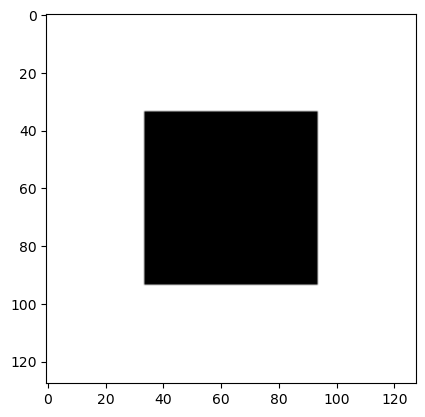

In [43]:
# Plotting only the mask
plt.imshow(mask, cmap="gray")

We have to change our function to receive as a parameter the mask coordinates!


Question:

- Since we use the elements outside of the mask to give our magnitude, how do i reshape it so that it fits the mask shape? Since they will be different
- How can we do this? Its here that comes the Kriging component, right?

Just reviewing Kriging:


We want to calculate each "unknown" (mask) pixel based on the surroundings, just like in geostats. To do so, we add some weights to each pixel, so it becomes a linear problem:

pixel_m = w1 * p_neighbor1 + w2 * p_neighbor2 + ... + wn * p_neighborN

Kriging method affirms that closer neighbors are more relevant, so their weights should be higher. To do so, he uses the measure of covariance (why not use the pixel distance - like euclidian distance or manhattan distance?).

I saw that it uses covariance between two pixels. How does this work? How can we measure the covariance with an unknown pixel? Do we use only the known pixels (generating a NxN covariance matrix)?


In [ ]:
def generate_gaussian_impaint(im, mask):
    u = np.mean(im[mask], axis=(0, 1))


    tu = (im - u)


    single_channel_noise = np.array(generate_gausian_matrix(tu.shape[0:2]))

    W = np.dstack([single_channel_noise, single_channel_noise, single_channel_noise])

    tu_fft = np.fft.fft2(tu, axes=(0, 1))
    tu_mag = np.abs(tu_fft)
    tu_phase = np.angle(tu_fft)


    W_fft = np.fft.fft2(W, axes=(0, 1))
    W_mag = np.abs(W_fft)
    W_phase = np.angle(W_fft)

    # Assemble both
    result = tu_mag * np.exp(1j * W_phase)

    image_gaussian_noise = np.fft.ifft2(result, axes=(0, 1))


    # Remember to get that ifft returns a complex number!
    result = u + np.real(image_gaussian_noise)

    # The previous operations make it so that result has negative values, we need to clip them
    final_result = np.clip(result, 0, 255).astype(np.uint8)

    plt.imshow(final_result)

    plt.show()
    return final_result

In [32]:
mask = np.any(im_hole != 0, axis=-1)

# Calculating the mean
mean_rgb = im_hole[mask].mean(axis=0)

mean_rgb

array([139.66348,  53.43453,  79.51416], dtype=float32)

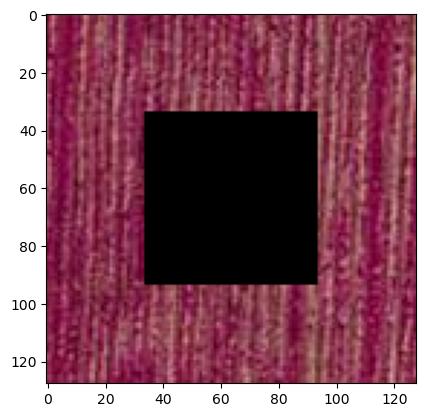

In [48]:
plt.imshow(im_hole.astype(int))

plt.show()